In [1]:
import os
import io
import re
import networkx as nx
import netwulf as nw 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_marvel = pd.read_csv("files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]

df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'

df_comics = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)
df_comics['creation'] = np.empty(len(df_comics),dtype="<U10")

In [3]:
import requests
import datetime
import json
from tqdm import tqdm
import numpy as np
from urllib import request
from urllib.parse import quote
import os
import pickle

BASE_URL = "http://en.wikipedia.org/w/api.php"

time_stamp_dict = {}

for idx, row in tqdm(df_comics.iloc[:].iterrows()):
    wikilink = row["WikiLink"]
    character_name = row["CharacterName"]
    creations = []
    for link in wikilink.split('|'):
        parameters = { 'action': 'query',
                   'format': 'json',
                   'continue': '',
                   'titles': link,
                   'prop': 'revisions',
                   'rvprop': 'content|timestamp',
                    'rvslots': '*',
                   'rvdir': 'newer',
                   'redirects': 'yes', #Took me a while to find this. Now we get pages
                      #that we should be redirected to! (Achebe (comics) redirects to
                      #achebe (character)!)
                   'rvlimit': 'max',
                     'rvstart': '2006-01-20T00:00:00Z',
                     'rvend': '2006-01-27T00:00:00Z'}
        total_revisions = 0

        revid_timestamp = dict()
        count = 0
        while True:
            wp_call = requests.get(BASE_URL, params=parameters)
            response = wp_call.json()
        

            for page_id in response['query']['pages']:
                
                if 'revisions' in response['query']['pages'][page_id].keys():
                
                    total_revisions += len(response['query']['pages'][page_id]['revisions'])
                    response['query']['pages'][page_id]['revisions']

                    for revision in response['query']['pages'][page_id]['revisions']:
                        if count == 0:
                            time_stamp_dict[revision['timestamp']] = (wikilink, set(re.findall(r"\[\[(.*?)\]\]",str(revision['slots']['main']['*']))))
                            prev_ts = time_stamp_dict[revision['timestamp']][1]
                        else:
                            if not set(re.findall(r"\[\[(.*?)\]\]",str(revision['slots']['main']['*'])))-prev_ts == set():
                                time_stamp_dict[revision['timestamp']] = (wikilink, set(re.findall(r"\[\[(.*?)\]\]",str(revision['slots']['main']['*'])))-prev_ts)
                        try:
                            prev_ts.update(time_stamp_dict[revision['timestamp']][1])
                        except:
                            continue
                        count += 1

            if 'continue' in response:
                parameters['continue'] = response['continue']['continue']
                parameters['rvcontinue'] = response['continue']['rvcontinue']

            else:
                break
        

2303it [13:08,  2.92it/s]


In [4]:
sorted_ts_dict = dict(sorted(time_stamp_dict.items()))

In [107]:
sorted_ts_dict_copy = sorted_ts_dict.copy()
deleted = []
for key, value in sorted_ts_dict.items():
    if value[0] not in deleted:
        deleted.append(value[0])
        del sorted_ts_dict_copy[key]
        

In [108]:
edge_list = []
for key, value in sorted_ts_dict_copy.items():
    source = value[0]
    for target in value[1]:
        if target in list(df_comics['WikiLink']):
            key = key.replace('-','').replace('T','').replace(':','').replace('Z','')
            edge_list.append([source, target, int(key)])


In [109]:
temp_to_save = pd.DataFrame(edge_list, columns=['Source', 'Target', 'Timeset'])
temp_to_save['Type'] = ['Directed' for i in range(len(temp_to_save))]
temp_to_save.to_csv('timestamp_edge_list_onlyadded.csv', index=False)

In [110]:
node_dict = {}
for idx, row in temp_to_save.iterrows():
    source = row['Source']
    try:
        if node_dict[source] > row['Timeset']:
            node_dict[source] = row['Timeset']
    except:
        node_dict[source] = row['Timeset']

for idx, row in temp_to_save.iterrows():
    target = row['Target']
    try:
        if node_dict[target] > row['Timeset']:
            node_dict[target] = row['Timeset']
    except:
        node_dict[target] = row['Timeset']        
temp_to_save = pd.DataFrame(list(node_dict.items()),columns=['Id','Timeset'])
temp_to_save['Universe'] = np.zeros(len(temp_to_save))
for idx, row in temp_to_save.iterrows():
    uni = df_comics[df_comics['WikiLink']==row['Id']]['universe'].item()

    temp_to_save['Universe'][idx] = uni
temp_to_save.to_csv('timestamp_node_list_onlyadded.csv', index=False)


<ipython-input-110-41aa62f16024>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_to_save['Universe'][idx] = uni


In [111]:
temp_to_save

,Id,Timeset,Universe
0,Sunfire (comics),20060120153540,Marvel
1,Callisto (comics),20060120194552,Marvel
2,Thundra,20060121123607,Marvel
3,Nightwing,20060121155159,DC
4,Man-Thing,20060121222254,Marvel
...,...,...,...
77,Shuma-Gorath,20060125215050,Marvel
78,Nicholas Scratch,20060126160405,Marvel
79,Doctor Mid-Nite,20060126193954,DC
80,Professor X,20060126193954,Marvel


In [5]:
frdf = pd.read_csv('edit-frwikiquote/out.edit-frwikiquote', sep='\t', header=None)

In [6]:
frdf = frdf.sort_values(3)
frdf.head()

,0,1,2,3
9730,875,353,1,1016068151
9731,876,353,1,1016068395
165076,22,19731,1,1026345997
165077,11,19731,1,1026518430
165078,4005,19731,1,1028727140


In [7]:
def get_summed_list(dictionary):
    G = nx.DiGraph()
    G.add_nodes_from(df_comics['WikiLink'])
    count = 0
    for idx, (key, (source, targets)) in enumerate(dictionary.items()):
        if idx == 0:
            prev_neighbors = list(G.neighbors(source))
            prev_predecessors = list(G.predecessors(source))
            continue
        edges = [(source,i) for i in targets if i in G.nodes]
        G.add_edges_from(edges)

        if source in prev_neighbors or source in prev_predecessors:
            count += 1

        prev_predecessors = list(G.predecessors(source))
        prev_neighbors = list(G.neighbors(source))
    return count

In [8]:
import numpy as np
import random
def permute_dict_keys(dictionary, seed=0):
    random.seed(seed)
    keys = list(dictionary.keys())
    random.shuffle(keys)
    permuted_dict = dict([(key, dictionary[key]) for key in keys])
    return permuted_dict
def permute_rows(df, seed=0):
    new_df = df.sample(frac=1, random_state=seed).reset_index()
    return new_df

In [9]:
def get_summed_list_df(df):
    G = nx.DiGraph()
    count = 0
    for (idx, row) in df.iterrows():
        G.add_edge(row[0],row[1])

        try:
            if(row[0] in prev_neighbors or source in prev_predecessors):
                count += 1
        except:
            pass
        prev_predecessors = list(G.predecessors(row[0]))
        prev_neighbors = list(G.neighbors(row[0]))
    return count

In [10]:
# do permutation test:
perm_sums = []
for seed in tqdm(range(10)):
    permuted = permute_rows(df=frdf, seed=seed)
    perm_sums.append(get_summed_list_df(permuted))

100%|██████████| 10/10 [01:44<00:00, 10.41s/it]


In [11]:
true_sum = get_summed_list_df(frdf)

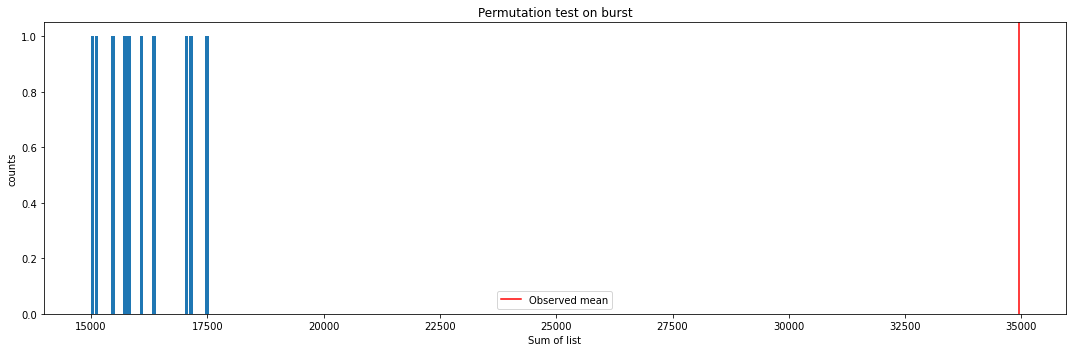

In [12]:
fig, ax = plt.subplots(figsize=(15,5))

bins = np.linspace(min(perm_sums), max(perm_sums), 30)


hist, edges = np.histogram(perm_sums, bins=bins)

x = (edges[1:]+edges[:-1])/2
width = edges[1] - edges[0]

ax.bar(x, hist, width=width*0.93)
ax.axvline(true_sum, c='r', label='Observed mean')


ax.set_title("Permutation test on burst")

ax.set_xlabel("Sum of list")

ax.set_ylabel("counts")

ax.legend()
plt.tight_layout()
plt.show()

In [13]:
# do permutation test:
perm_sums = []
for seed in tqdm(range(1000)):
    permuted = permute_dict_keys(dictionary=sorted_ts_dict, seed=seed)
    perm_sums.append(get_summed_list(permuted))

100%|██████████| 1000/1000 [00:18<00:00, 54.33it/s]


In [14]:
true_sum = get_summed_list(sorted_ts_dict)

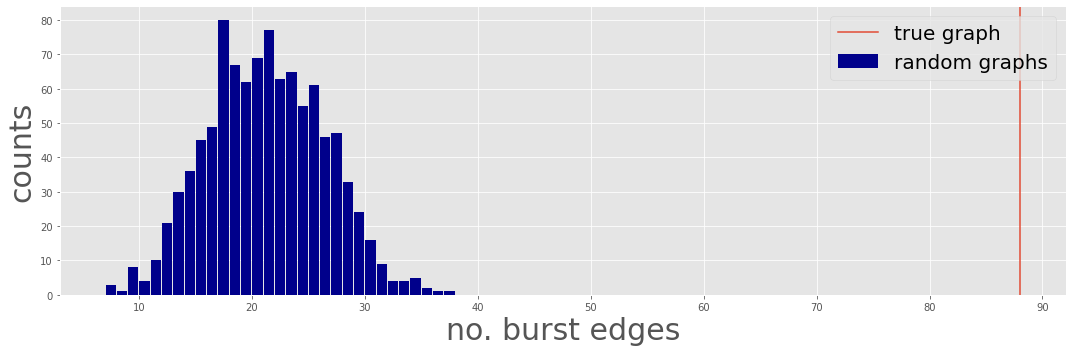

In [15]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,5))

bins = np.arange(min(perm_sums), max(perm_sums), 1)


hist, edges = np.histogram(perm_sums, bins=bins)

x = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]

ax.bar(x, hist,color='darkblue', width=width*0.91, label='random graphs')
ax.axvline(true_sum, label='true graph')

ax.set_xlabel("no. burst edges", fontsize=30)

ax.set_ylabel("counts", fontsize=30)

ax.legend(fontsize=20, loc='upper right')
plt.tight_layout()
plt.savefig('edge_burst_detection.png')
plt.show()

In [16]:
def same_coms(dictionary):
    G = nx.DiGraph()
    G.add_nodes_from(df_comics['WikiLink'])
    communities = []
    community = set()
    count = []
    output = 0
    for idx, (key, (source, targets)) in enumerate(dictionary.items()):
        if idx == 0:
            count.append(0)
            prev_neighbors = list(G.neighbors(source))
            prev_predecessors = list(G.predecessors(source))
            continue
        edges = [(source,i) for i in targets if i in G.nodes]
        G.add_edges_from(edges)
        
        source_neighborhood = list(G.predecessors(source))+list(G.neighbors(source))+list(source)
        
        

        if source in prev_neighbors or source in prev_predecessors:
            if len(community.intersection(source_neighborhood)) == 0:
                output += 1
            count.append(output)
            community.update(prev_neighbors+prev_predecessors)
            community.update(source_neighborhood)
            
        else:
            count.append(0)
            community = set()
        prev_predecessors = list(G.predecessors(source))
        prev_neighbors = list(G.neighbors(source))
    return count

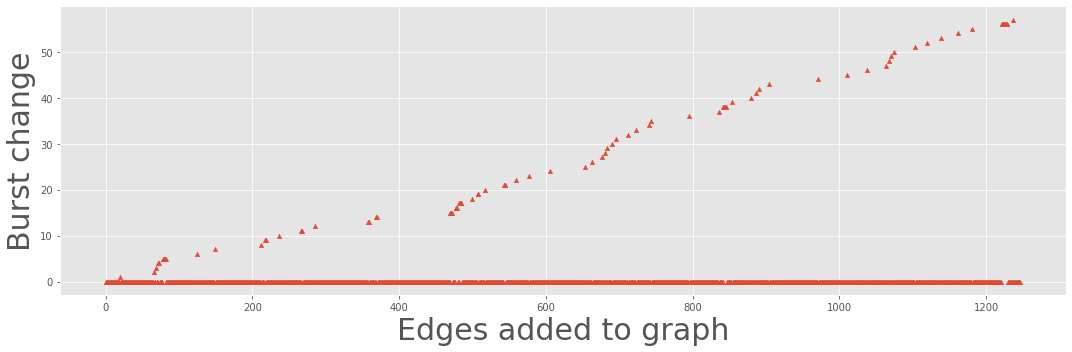

In [31]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Edges added to graph', fontsize=30)
plt.ylabel('Burst change', fontsize = 30)
plt.scatter(np.arange(len(sorted_ts_dict)), same_coms(sorted_ts_dict), marker='^', s=20)
plt.tight_layout()
plt.savefig('change_burst_detection.png')